All advanced applications of lanugage need a way to *consume* text or *produce* text.

Language modelling is a good difficulty task that helps train embeddings for both.

Let's work towards the model in [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/abs/1708.02182).

Transformers perform much better but are apparently harder to train; so let's start easy.

## Download the data

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from foundation import *
from pathlib import Path

Download [Wikitext](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) as described in [Pointer Sentinal Mixture Models](https://arxiv.org/abs/1609.07843)

In [3]:
URL_WIKITEXT = {
    '2': 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip',
    '2-word': 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip',
    '103-word': 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip',
    '103': 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip',
}

In [4]:
download(URL_WIKITEXT['2'], 'data/wikitext2-raw.zip')

In [5]:
!unzip -qu -d data data/wikitext2-raw.zip

In [6]:
download(URL_WIKITEXT['2-word'], 'data/wikitext2.zip')

In [7]:
!unzip -qu -d data data/wikitext2.zip

Is fastai's version the same?

In [8]:
download('https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz', 'data/fastai-wikitext/wikitext.tgz')

In [9]:
!tar -xf data/fastai-wikitext/wikitext.tgz -C data/fastai-wikitext 

## Explore the Data

All wikitext documents have been pretokenized. It's clear *most* wiki markdown has been stripped (excluding the `=` signts in headers).
The most notable difference is the word level models have `<unk>` out of vocabulary tokens already.

The tokenized data, but rare tokens not removed. I think Moses was used for tokenisation, and some custom processing to remove Wiki markup.

In [23]:
!head data/wikitext-2-raw/wiki.train.raw

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series 

Preprocessed tokens, with `<unk>` for tokens that occur less than 3 times

In [11]:
!head data/wikitext-2/wiki.train.tokens

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Char

Fastai's version looks different

In [12]:
!head data/fastai-wikitext/wikitext-2/train.csv

" 
 = 2013 – 14 York City F.C. season = 
 
 The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . 
 Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation zone on goal difference , before a 17 @-@ match unbeaten run saw the team finish in seventh @-@ place in the 24 @-@ team 2013 – 14 Football League Two . This meant York qualified for the play @-@ offs , and they were eliminated in the semi @-@ final by Fleetwood Town . York were knocked out of the 2013 – 14 FA Cup , Football League Cup and Football League Trophy in their opening round matches . 
 35 playe

There are some specially marked up characters:

* @-@ is an in-word hyphen
* @.@ is a period separator in a number
* @,@ is a comma separator in a number

In [13]:
!grep -o '@[^ ]*@' data/wikitext-2/wiki.train.tokens | sort | uniq -c | sort -nr | head -n 10

  16906 @-@
   3194 @.@
   2699 @,@


The fastai version is different - it is slightly smaller!

In [14]:
!wc -l data/wikitext-2-raw/*

    4358 data/wikitext-2-raw/wiki.test.raw
   36718 data/wikitext-2-raw/wiki.train.raw
    3760 data/wikitext-2-raw/wiki.valid.raw
   44836 total


In [15]:
!wc -l data/wikitext-2/*

    4358 data/wikitext-2/wiki.test.tokens
   36718 data/wikitext-2/wiki.train.tokens
    3760 data/wikitext-2/wiki.valid.tokens
   44836 total


In [16]:
!wc -l data/fastai-wikitext/wikitext-2/*

    3807 data/fastai-wikitext/wikitext-2/test.csv
   37333 data/fastai-wikitext/wikitext-2/train.csv
   41140 total


# Load the Data

In [4]:
path = Path('data/wikitext-2/')
data = {}
for split in ('train', 'valid', 'test'):
    with open(path / f'wiki.{split}.tokens') as f:
        data[split] = f.read()

We have different sections. There is no continuity *between* sections but *within* sections, so it makes sense to shuffle at a section level.

All the sections

In [5]:
section_names = re.findall(r'\n \n = ([^=]*) = \n \n', '\n \n' + data['train'])
print(len(section_names))
section_names[:20]

600


['Valkyria Chronicles III',
 'Tower Building of the Little Rock Arsenal',
 '<unk> Mary Barker',
 "Gambia women 's national football team",
 'Plain maskray',
 '2011 – 12 Columbus Blue Jackets season',
 'Gregorian Tower',
 "There 's Got to Be a Way",
 'Nebraska Highway 88',
 'USS Atlanta ( 1861 )',
 'Jacqueline Fernandez',
 'John Cullen',
 'SMS Erzherzog Ferdinand Max',
 'Ancient Egyptian deities',
 'South of Heaven',
 'General aviation in the United Kingdom',
 'SMS Zrínyi',
 'Geopyxis carbonaria',
 'Gold dollar',
 'Johnson – Corey – Chaykovsky reaction']

Split the text into sections

In [7]:
def split_wiki_sections(text):
    section_start = re.compile(r'\n \n = [^=]* = \n \n')
    ans = []
    idx = 0
    while True:
        m = section_start.search(text[idx:])
        if m:
            ans.append(text[idx: idx+m.start()])
            idx += m.start() + 1
        else:
            ans.append(text[idx:-1])
            return(ans)

In [8]:
train = split_wiki_sections(data['train'])
val = split_wiki_sections(data['valid'])
test = split_wiki_sections(data['test'])
len(train), len(val), len(test)

(600, 60, 60)

In [9]:
import matplotlib.pyplot as plt

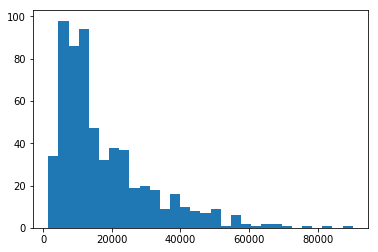

In [10]:
l = [len(t) for t in train]
plt.hist(l, bins=30)
None

Makes sense: Bob Dylan is a long topic

In [11]:
print(train[l.index(max(l))])

 
 = Bob Dylan = 
 
 Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman , May 24 , 1941 ) is an American singer @-@ songwriter , artist and writer . He has been influential in popular music and culture for more than five decades . Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest , although Dylan repudiated suggestions from journalists that he was a spokesman for his generation . Nevertheless , early songs such as " Blowin ' in the Wind " and " The Times They Are a @-@ <unk> ' " became anthems for the American civil rights and anti @-@ war movements . After he left his initial base in the American folk music revival , his six @-@ minute single " Like a Rolling Stone " altered the range of popular music in 1965 . His mid @-@ 1960s recordings , backed by rock musicians , reached the top end of the United States music charts while also attracting <unk> and criticism from others in the folk movement . 
 Dylan 's lyrics have incorporated various 

In [31]:
print(train[l.index(min(l))])

 
 = M @-@ 122 ( Michigan highway ) = 
 
 M @-@ 122 was a state trunkline highway in the US state of Michigan entirely in the city of St. Ignace . The highway connected US Highway 2 ( US 2 ) to the State Highway Ferry Dock used before the Mackinac Bridge was built . It was retired and the road returned to local control in 1957 . 
 
 = = Route description = = 
 
 Prior to the opening of the Mackinac Bridge , travelers wishing to venture from St. Ignace to Mackinaw City had to do so via ferry . M @-@ 122 began at US 2 ( now Business Loop Interstate 75 ) near Straits State Park and traveled through town along Ferry Road where it ran southeasterly from the main highway . East of <unk> Street M @-@ 122 curved around to the east near <unk> Street . The highway ended at the State Ferry Docks on the southeast side of the city next to the Coast Guard station . 
 
 = = History = = 
 
 M @-@ 122 was initially assumed into the state highway system in 1929 as a connector between US 31 and Straits S

In [32]:
print(train[-1])

 
 = Common starling = 
 
 The common starling ( Sturnus vulgaris ) , also known as the European starling , or in the British Isles just the starling , is a medium @-@ sized <unk> bird in the starling family , Sturnidae . It is about 20 cm ( 8 in ) long and has glossy black plumage with a metallic <unk> , which is speckled with white at some times of year . The legs are pink and the bill is black in winter and yellow in summer ; young birds have <unk> plumage than the adults . It is a noisy bird , especially in communal roosts and other gregarious situations , with an <unk> but varied song . Its gift for mimicry has been noted in literature including the <unk> and the works of Pliny the Elder and William Shakespeare . 
 The common starling has about a dozen subspecies breeding in open habitats across its native range in temperate Europe and western Asia , and it has been introduced to Australia , New Zealand , Canada , United States , Mexico , Peru , Argentina , the Falkland Islands , 

## Prepare the data

Follow tokenization in https://github.com/salesforce/awd-lstm-lm/blob/master/data.py to compare benchmarks.

In [12]:
from collections import Counter

Could easily replace wiht a generator if desirable

In [13]:
EOS = '<eos>'
def tokenise(s, eos=True):
    tokens = []
    for line in s.split('\n'):
        toks = line.split()
        toks.append(EOS)
        tokens += toks
    return tokens

In [14]:
tokens = Counter()
for article in train:
    tokens.update(tokenise(article))

In [15]:
len(tokens)

33278

Most common tokens

In [16]:
sorted([(k, v) for k, v in tokens.items()], key=lambda x: -x[1])[:30]

[('the', 113161),
 (',', 99913),
 ('.', 73388),
 ('of', 56889),
 ('<unk>', 54625),
 ('and', 50603),
 ('in', 39453),
 ('to', 39190),
 ('<eos>', 36718),
 ('a', 34237),
 ('=', 29570),
 ('"', 28309),
 ('was', 20985),
 ('The', 17602),
 ('@-@', 16906),
 ('that', 14135),
 ('as', 14021),
 ("'s", 14002),
 ('on', 13678),
 ('for', 13307),
 ('with', 12606),
 ('by', 12148),
 (')', 12004),
 ('(', 11992),
 ('is', 11637),
 ('from', 8941),
 ('his', 8395),
 ('at', 8186),
 ('were', 7330),
 ('it', 6748)]

Least common tokens (all have frequency of 3 - because tokens with frequency less than 3 were dropped).

This is questionable; maybe it should be dropped if it didn't appear in at least 2 different articles.

We *could* choose to cap infrequent words here - hyperparameter.

In [17]:
sorted([(k, v) for k, v in tokens.items()], key=lambda x: -x[1])[-30:]

[('γ', 3),
 ('O.W.C.A.', 3),
 ('Urocerus', 3),
 ('Echinodontium', 3),
 ('yellowwoods', 3),
 ('tomentum', 3),
 ('secretion', 3),
 ('spruces', 3),
 ('Lewenthal', 3),
 ('Caprices', 3),
 ('étude', 3),
 ('études', 3),
 ('mineurs', 3),
 ('Sonatine', 3),
 ('Chants', 3),
 ('Sonate', 3),
 ('Philipp', 3),
 ('prefaced', 3),
 ('Souvenirs', 3),
 ('sonate', 3),
 ('Chant', 3),
 ('Kreutzer', 3),
 ('Forrester', 3),
 ('Zoromski', 3),
 ('roundabouts', 3),
 ('Tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('Nests', 3),
 ('gallinae', 3)]

Mapping tokens to numbers and back again

In [18]:
TOK_PAD = '<pad>'
TOK_UNK = '<unk>'

In [19]:
idx2tok = [TOK_PAD] + [x[0] for x in sorted([(k, v) for k, v in tokens.items()], key=lambda x: (-x[1], x[0]))]
tok2idx = {t:i for i, t in enumerate(idx2tok)}
def numericalise(x): return tok2idx[x]
n_tok = len(idx2tok)
n_tok

33279

Check mapping to unknown words is done correctly: we expect only tokens in training set to be in validation and test and that the ratio of `<unk>` is much higher in test.

In [20]:
val_tokens = Counter()
for article in val:
    val_tokens.update(tokenise(article))

In [21]:
test_tokens = Counter()
for article in test:
    test_tokens.update(tokenise(article))

In [22]:
all(tok in tok2idx for tok in val_tokens)

True

In [23]:
all(tok in tok2idx for tok in test_tokens)

True

There are more unknown tokens in val/test, which makes sense because we're removing words that don't appear at least 3 times in the *training* set

In [24]:
(tokens['<unk>'] / sum(tokens.values()), 
 val_tokens['<unk>'] / sum(val_tokens.values()), 
 test_tokens['<unk>'] / sum(test_tokens.values()))

(0.026153532366701968, 0.053839721382428346, 0.06197036270864808)

Note there's a weird effect here: our model gets full points for guessing `<unk>`. This is a bit silly since it it's better than guessing a wrong word, but not as good as guessing the true word.

A cheap way of building our tokens. A better way would include a way to shuffle the articles.

In [25]:
train_ds = ListContainer(tokenise('\n'.join(train)), tfms=[numericalise])
val_ds = ListContainer(tokenise('\n'.join(val)), tfms=[numericalise])
test_ds = ListContainer(tokenise('\n'.join(test)), tfms=[numericalise])

In [26]:
[train_ds[i] for i in range(10)]

[9, 11, 3932, 4429, 852, 11, 9, 9, 21729, 128]

In [92]:
train_ds[:10]

ListContainer (10 items)
['<eos>', '=', 'Valkyria', 'Chronicles', 'III', '=', '<eos>', '<eos>', 'Senjō', 'no']; Transformed by [<function numericalise at 0x7f5602618378>]

In [27]:
tr = train_ds[:-1].product(train_ds[1:])

In [28]:
from torch import nn, tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch

In [29]:
dl = DataLoader(tr, batch_size=4)

In [30]:
x, y = next(iter(dl))

In [31]:
x, y

(tensor([   9,   11, 3932, 4429]), tensor([  11, 3932, 4429,  852]))

### Batching and backpropagating

In [32]:
from fastai.text import TextList
import pandas as pd

For language modelling we want each *line* of our batch to be a contiguous part of the text.
So we break the text into equal sized chunks, and then produce bptt of that at a time

In [33]:
text = ("Gentle reader : This is a handbook about TEX , a new typesetting system intended for the "
        "creation of beautiful books %—% and especially for books that contain a lot of mathematics . "
        "By preparing a manuscript in TEX format , you will be telling a computer exactly how the "
        "manuscript is to be transformed").split()
' '.join(text)

'Gentle reader : This is a handbook about TEX , a new typesetting system intended for the creation of beautiful books %—% and especially for books that contain a lot of mathematics . By preparing a manuscript in TEX format , you will be telling a computer exactly how the manuscript is to be transformed'

Let's work out what we want. We cut up the text into sections and have parallel streams through the text.

Let's say we have bs=7 (i.e. 7 parallel streams), bptt = 4 (4 tokens per batch)

In [34]:
len(text)

55

In [35]:
55 / 7

7.857142857142857

We'll split it into 7 streams of length 7-8 (there's some ambiguity on how we handle end tokens)

In [36]:
streams = [text[i*8:i*8+8] for i in range(7)]
streams

[['Gentle', 'reader', ':', 'This', 'is', 'a', 'handbook', 'about'],
 ['TEX', ',', 'a', 'new', 'typesetting', 'system', 'intended', 'for'],
 ['the', 'creation', 'of', 'beautiful', 'books', '%—%', 'and', 'especially'],
 ['for', 'books', 'that', 'contain', 'a', 'lot', 'of', 'mathematics'],
 ['.', 'By', 'preparing', 'a', 'manuscript', 'in', 'TEX', 'format'],
 [',', 'you', 'will', 'be', 'telling', 'a', 'computer', 'exactly'],
 ['how', 'the', 'manuscript', 'is', 'to', 'be', 'transformed']]

Now each batch will grab the first 4 tokens from each stream

In [37]:
batch = [s[:4] for s in streams]
batch

[['Gentle', 'reader', ':', 'This'],
 ['TEX', ',', 'a', 'new'],
 ['the', 'creation', 'of', 'beautiful'],
 ['for', 'books', 'that', 'contain'],
 ['.', 'By', 'preparing', 'a'],
 [',', 'you', 'will', 'be'],
 ['how', 'the', 'manuscript', 'is']]

Unfortunately the last batch can end up non-square.

We either have to drop it or pad it

In [38]:
batch = [s[4:8] for s in streams]
batch

[['is', 'a', 'handbook', 'about'],
 ['typesetting', 'system', 'intended', 'for'],
 ['books', '%—%', 'and', 'especially'],
 ['a', 'lot', 'of', 'mathematics'],
 ['manuscript', 'in', 'TEX', 'format'],
 ['telling', 'a', 'computer', 'exactly'],
 ['to', 'be', 'transformed']]

Let's go with padding: each stream can start with at most one `<PAD>` character so we don't miss a word. May be overkill, but is best for testing. We'll need to treat is specially in the model.

Have n characters, and bs streams.

Number of characters per stream is: `l = (n+bs-1) // bs` (round up the division), and the number of pad characters is `n_pad = l * bs - n`.

Streams are then something like:
```
1     2     ...    l
l+1   l+2   ...    2l
2l+1  2l+2  ...    3l
<pad> 3l+1  ...    4l-1
<pad> ...
```

Then we need to break this into sequences of length `bptt`. The number of sequences is `s = (l + bptt - 1) // bptt`, and we're going to need additional padding on each sequence of length `n_seq_pad = bptt * s - l`, which is at most `bptt - 1` characters long.

So we then get:
```
<pad> <pad> 1     2     ...    l
<pad> <pad> l+1   l+2   ...    2l
<pad> <pad> 2l+1  2l+2  ...    3l
<pad> <pad> <pad> 3l+1  ...    4l-1
<pad> <pad> <pad> ...
```

So the process in steps is:

* Find out l, n_pad, s, n_seq_pad (can use divmod)
* Add padding to sequence (or indexer)
* Add lookup that retrives a block of size bs from each of the sequences

Here's a pure indexing solution adapted from `12_text` 

In [39]:
class LM_PreLoader():
    def __init__(self, data, bs=64, bptt=70, shuffle=False):
        self.data,self.bs,self.bptt,self.shuffle = data,bs,bptt,shuffle
        total_len = sum([len(t) for t in data])
        self.n_batch = total_len // bs
        self.batchify()
    
    def __len__(self): return ((self.n_batch-1) // self.bptt) * self.bs
    
    def __getitem__(self, idx):
        source = self.batched_data[idx % self.bs]
        seq_idx = (idx // self.bs) * self.bptt
        return source[seq_idx:seq_idx+self.bptt],source[seq_idx+1:seq_idx+self.bptt+1]
    
    def batchify(self):
        texts = self.data
        if self.shuffle: texts = texts[torch.randperm(len(texts))]
        stream = torch.cat([tensor(t) for t in texts])
        self.batched_data = stream[:self.n_batch * self.bs].view(self.bs, self.n_batch)

Let's create our own solution (it may be slow)

In [40]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    return [l[i:i+n] for i in range(0, len(l), n)] if len(l) > 0 else []

In [41]:
def batch_seq_trunc(seq, bs, bptt):
    n = len(seq)
    len_stream, n_extra = divmod(n, bs)
    n_batch, n_batch_extra = divmod(len_stream, bptt)
    n -= n_extra + n_batch_extra * bs
    len_stream -= n_batch_extra
    
    streams = chunks(seq[:n], len_stream)
    batches = [chunks(s, bptt) for s in streams]
    
    return list(zip(*batches))

In [42]:
bst = batch_seq_trunc(text, 4, 3)
bst

[(['Gentle', 'reader', ':'],
  ['typesetting', 'system', 'intended'],
  ['for', 'books', 'that'],
  ['manuscript', 'in', 'TEX']),
 (['This', 'is', 'a'],
  ['for', 'the', 'creation'],
  ['contain', 'a', 'lot'],
  ['format', ',', 'you']),
 (['handbook', 'about', 'TEX'],
  ['of', 'beautiful', 'books'],
  ['of', 'mathematics', '.'],
  ['will', 'be', 'telling']),
 ([',', 'a', 'new'],
  ['%—%', 'and', 'especially'],
  ['By', 'preparing', 'a'],
  ['a', 'computer', 'exactly'])]

Check it's outputting the right size things

In [43]:
bs, bptt = 16, 70
for t in train:
    bst = batch_seq_trunc(tokenise(t), bs, bptt)
    # Should use almost all tokens
    assert len(tokenise(t)) - len(bst) * bs * bptt < bs * bptt
    for batch in bst:
        # All batches should be size bs
        assert len(batch) == bs
        for stream in batch:
            # Each item in a batch should be size bptt
            assert len(stream) == bptt

In [53]:
def lift(f): return lambda xs: [f(x) for x in xs]
def flatten1(l): return [x for y in l for x in y]

In [54]:
t = comply(['\n'.join, str.lstrip, tokenise, lift(numericalise)], train)

In [55]:
tx = comply([flatten1, lift(torch.LongTensor)], batch_seq_trunc(t[:-1], bs=7, bptt=4))
ty = comply([flatten1, lift(torch.LongTensor)], batch_seq_trunc(t[1:], bs=7, bptt=4))

In [56]:
dl = DataLoader(list(zip(tx, ty)), batch_size=7, shuffle=False)

In [57]:
xbs, ybs = [], []
for xb, yb in dl:
    xbs.append(xb)
    ybs.append(yb)
    if len(xbs) >= 2: break

xb.shape, yb.shape

(torch.Size([7, 4]), torch.Size([7, 4]))

In [58]:
def unnumericalise(t):
    return [idx2tok[x] for x in t]

In [59]:
[unnumericalise(seq) for seq in xbs[0]]

[['=', 'Valkyria', 'Chronicles', 'III'],
 ['<unk>', '<unk>', 'Long', 'and'],
 ['footage', 'from', 'her', 'live'],
 ['"', 'his', 'profound', 'impact'],
 ['trial', 'because', 'the', 'jury'],
 ['prominent', 'in', 'the', 'mid'],
 ['2006', ',', 'the', 'athletic']]

In [60]:
[unnumericalise(seq) for seq in ybs[0]]

[['Valkyria', 'Chronicles', 'III', '='],
 ['<unk>', 'Long', 'and', 'published'],
 ['from', 'her', 'live', 'performances'],
 ['his', 'profound', 'impact', 'on'],
 ['because', 'the', 'jury', 'was'],
 ['in', 'the', 'mid', '@-@'],
 [',', 'the', 'athletic', 'department']]

In [61]:
[unnumericalise(seq) for seq in xbs[1]]

[['=', '<eos>', '<eos>', 'Senjō'],
 ['published', 'in', '1986', '.'],
 ['performances', 'of', 'the', 'song'],
 ['on', 'popular', 'music', 'and'],
 ['was', 'racially', 'biased', ','],
 ['@-@', '20th', 'century', ','],
 ['department', 'was', 'ranked', '79th']]

In [62]:
[unnumericalise(seq) for seq in ybs[1]]

[['<eos>', '<eos>', 'Senjō', 'no'],
 ['in', '1986', '.', 'This'],
 ['of', 'the', 'song', 'in'],
 ['popular', 'music', 'and', 'American'],
 ['racially', 'biased', ',', '<unk>'],
 ['20th', 'century', ',', 'but'],
 ['was', 'ranked', '79th', 'in']]

In [63]:
train_data = [[tok2idx[tok] for tok in tokenise(text)] for text in train]
val_data = [[tok2idx[tok] for tok in tokenise(text)] for text in val]
test_data = [[tok2idx[tok] for tok in tokenise(text)] for text in test]

We more or less end up reimplementing fastai's version; so let's use that.

We'll need to call batchify after each epoch to reshuffle

In [64]:
class LM_PreLoader():
    def __init__(self, data, bs=64, bptt=70, shuffle=False):
        self.data,self.bs,self.bptt,self.shuffle = data,bs,bptt,shuffle
        total_len = sum([len(t) for t in data])
        self.n_batch = total_len // bs
        self.batchify()
    
    def __len__(self): return ((self.n_batch-1) // self.bptt) * self.bs
    
    def __getitem__(self, idx):
        source = self.batched_data[idx % self.bs]
        seq_idx = (idx // self.bs) * self.bptt
        return source[seq_idx:seq_idx+self.bptt],source[seq_idx+1:seq_idx+self.bptt+1]
    
    def batchify(self):
        texts = self.data
        if self.shuffle: texts = [texts[i] for i in torch.randperm(len(texts))]
        stream = torch.cat([tensor(t) for t in texts])
        self.batched_data = stream[:self.n_batch * self.bs].view(self.bs, self.n_batch)

In [65]:
t = LM_PreLoader(train_data, bs=7, bptt=4)

In [66]:
dl = DataLoader(t, batch_size=7, shuffle=False)

In [67]:
xbs, ybs = [], []
for xb, yb in dl:
    xbs.append(xb)
    ybs.append(yb)
    if len(xbs) >= 2: break

xb.shape, yb.shape

(torch.Size([7, 4]), torch.Size([7, 4]))

In [68]:
[unnumericalise(seq) for seq in xbs[0]], [unnumericalise(seq) for seq in xbs[1]]

([['<eos>', '=', 'Valkyria', 'Chronicles'],
  ['Long', 'and', 'published', 'in'],
  ['of', 'the', 'song', 'in'],
  ['American', 'culture', ',', 'marked'],
  ['judge', 'was', 'a', 'racist'],
  ['pioneering', 'a', 'backwards', 'and'],
  ['Directors', 'of', 'Athletics', '(']],
 [['III', '=', '<eos>', '<eos>'],
  ['1986', '.', 'This', 'novel'],
  ['New', 'York', 'City', 'and'],
  ['by', 'lyrical', 'compositions', 'of'],
  [',', 'and', 'noted', 'that'],
  ['head', '@-@', 'first', 'technique'],
  ['<unk>', ')', '.', 'Along']])

We may need to do some cleaning wiht multiple `<eos>` tokens...

In [69]:
[unnumericalise(seq) for seq in ybs[0]], [unnumericalise(seq) for seq in ybs[1]]

([['=', 'Valkyria', 'Chronicles', 'III'],
  ['and', 'published', 'in', '1986'],
  ['the', 'song', 'in', 'New'],
  ['culture', ',', 'marked', 'by'],
  ['was', 'a', 'racist', ','],
  ['a', 'backwards', 'and', 'head'],
  ['of', 'Athletics', '(', '<unk>']],
 [['=', '<eos>', '<eos>', 'Senjō'],
  ['.', 'This', 'novel', ','],
  ['York', 'City', 'and', 'Japan'],
  ['lyrical', 'compositions', 'of', 'extraordinary'],
  ['and', 'noted', 'that', 'the'],
  ['@-@', 'first', 'technique', 'in'],
  [')', '.', 'Along', 'with']])

Remember: we'll need to add a hook to call batchify between epochs to actually do the shuffle

In [70]:
def lm_dataloader(data, bs=64, bptt=70, shuffle=False):
    return DataLoader(LM_PreLoader(train_data, bs, bptt, shuffle=shuffle),
                      batch_size=bs, shuffle=False)

In [71]:
bs, bptt = 64, 70

In [72]:
train_dl = lm_dataloader(train_data, bs, bptt, shuffle=True)
val_dl = lm_dataloader(val_data, bs, bptt, shuffle=False)

In [73]:
xb, yb = next(iter(train_dl))
[unnumericalise(x)[:7] for x in xb][:2]

[['<eos>', '=', 'Aston', 'Villa', 'F.C.', '=', '<eos>'],
 ['<eos>', 'Prior', 'to', '1895', 'two', '6', '@-@']]

In [74]:
xb, yb = next(iter(train_dl))
[unnumericalise(x)[:7] for x in xb][:2]

[['<eos>', '=', 'Aston', 'Villa', 'F.C.', '=', '<eos>'],
 ['<eos>', 'Prior', 'to', '1895', 'two', '6', '@-@']]

In [75]:
train_dl.dataset.batchify()
xb, yb = next(iter(train_dl))
[unnumericalise(x)[:7] for x in xb][:2]

[['<eos>', '=', 'Pokiri', '=', '<eos>', '<eos>', 'Pokiri'],
 ['Cathedral', 'and', 'Christ', 'Church', 'as', 'well', 'as']]

## Build a very stupid benchmark

Just always guess the next word is 'the'

In [76]:
x, y = next(iter(val_dl))

5.4% accuracy

In [77]:
avg = 0
for x, y in iter(val_dl):
    avg += (y == 1).float().mean().item()
avg /= len(val_dl)
avg

0.054183112281522526

# Super simple stateless Language Model

In [78]:
embedding_dim = 50

In [79]:
emb = nn.Embedding(n_tok, embedding_dim, padding_idx=0)

In [80]:
lin_out = nn.Linear(embedding_dim, n_tok)

In [81]:
relu = nn.ReLU()

In [82]:
xb.shape

torch.Size([64, 70])

In [738]:
exb = relu(emb(xb))
exb.shape

torch.Size([64, 70, 50])

In [747]:
lxb = lin_out(exb)
lxb.shape, yb.shape

(torch.Size([64, 70, 33279]), torch.Size([64, 70]))

In [758]:
lxb.view(-1, n_tok).shape, yb.view(-1).shape

(torch.Size([4480, 33279]), torch.Size([4480]))

In [768]:
F.cross_entropy(lxb.view(-1, n_tok), yb.view(-1))

tensor(10.4933, grad_fn=<NllLossBackward>)

In [83]:
class LinearLM(nn.Module):
    def __init__(self, n_tok, embedding_dim, hidden_dims, padding_idx=None):
        super().__init__()
        internal_dims = [embedding_dim] + listify(hidden_dims) + [n_tok]
        layers = [nn.Embedding(n_tok, embedding_dim, padding_idx=padding_idx)]
        for n_in, n_out in zip(internal_dims[:-1], internal_dims[1:]):
            layers += [nn.ReLU(), nn.Linear(n_in, n_out)]
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): return self.layers(x)

In [84]:
lm = LinearLM(n_tok, 50, [])
lxb = lm(xb)
lxb.shape

torch.Size([64, 70, 33279])

In [85]:
def flat_cross_entropy(pred, target):
    target = target.view(-1)
    size = target.shape[0]
    pred = pred.view(size, -1)
    return F.cross_entropy(pred, target)

In [86]:
class Databunch(NamedTuple):
    train_dl: DataLoader
    valid_dl: DataLoader
        
data = Databunch(train_dl, val_dl)

In [87]:
learn = Learner(lm, data, flat_cross_entropy, cbs=[Progress()])

In [88]:
learn.fit(1)

## Build a very simple vanilla RNN Language Model

In [703]:
embedding_dim = 50
hidden_dim = 40

In [704]:
emb = nn.Embedding(n_tok, embedding_dim, padding_idx=0)

In [707]:
exb = emb(xb)
xb.shape, exb.shape

(torch.Size([64, 70]), torch.Size([64, 70, 50]))

In [706]:
rnn = nn.RNN(input_size=embedding_dim,
             hidden_size=hidden_dim)

In [712]:
# **input** of shape `(seq_len, batch, input_size)`: 
# exb is bs x seq_len x input_size
rxb, hidden = rnn(exb.transpose(0,1))
rxb.shape, hidden.shape

(torch.Size([70, 64, 40]), torch.Size([1, 64, 40]))

In [713]:
lin_out = nn.Linear(hidden_dim, n_tok)

In [716]:
oxb = lin_out(rxb)
oxb.shape

torch.Size([70, 64, 33279])